In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Import libraries

In [ ]:
# Core libraries
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import pickle

# Visualization
import matplotlib.pyplot as plt
import matplotlib.figure as fig
import matplotlib.cm as cm
import seaborn as sns

# Data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score,
    recall_score, f1_score, roc_curve,
    confusion_matrix, classification_report,
    precision_recall_curve, auc
)

# Deep learning framework
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model, save_model
from tensorflow.keras.layers import (
    Dense, LSTM, Dropout,
    Conv1D, MaxPooling1D,
    Conv2D, MaxPooling2D,
    Flatten, Input,
    TimeDistributed, Reshape, BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint,
    ReduceLROnPlateau, TensorBoard
)
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

Sorting dataset


In [ ]:
# Path to your dataset folder
dataset_path = '/content/drive/MyDrive/DDoS_Dataset/'

# Lists to store training and testing file paths
dfps_train = []
dfps_test = []

# Walk through the directory and collect file paths
import os
for filename in os.listdir(dataset_path):
    file_path = os.path.join(dataset_path, filename)
    if filename.endswith('-training.parquet'):
        dfps_train.append(file_path)
        print(f"Found training file: {filename}")
    elif filename.endswith('-testing.parquet'):
        dfps_test.append(file_path)
        print(f"Found testing file: {filename}")

# Print summary
print(f"\nTotal training files found: {len(dfps_train)}")
print(f"Total testing files found: {len(dfps_test)}")

Found testing file: NetBIOS-testing.parquet
Found training file: LDAP-training.parquet
Found training file: MSSQL-training.parquet
Found testing file: NTP-testing.parquet
Found training file: Portmap-training.parquet
Found testing file: Syn-testing.parquet
Found training file: NetBIOS-training.parquet
Found testing file: DNS-testing.parquet
Found testing file: LDAP-testing.parquet
Found testing file: MSSQL-testing.parquet
Found testing file: SNMP-testing.parquet
Found training file: Syn-training.parquet
Found testing file: UDPLag-testing.parquet
Found testing file: UDP-testing.parquet
Found training file: UDP-training.parquet
Found testing file: TFTP-testing.parquet
Found training file: UDPLag-training.parquet

Total training files found: 7
Total testing files found: 10


In [ ]:
# Common Prefixes in both lists

train_prefixes = [dfp.split('/')[-1].split('-')[0] for dfp in dfps_train]
test_prefixes = [dfp.split('/')[-1].split('-')[0] for dfp in dfps_test]

common_prefixes = list(set(train_prefixes).intersection(test_prefixes))

# Filter the dataframes to only include the common prefixes
dfps_train = [dfp for dfp in dfps_train if dfp.split('/')[-1].split('-')[0] in common_prefixes]
dfps_test = [dfp for dfp in dfps_test if dfp.split('/')[-1].split('-')[0] in common_prefixes]

In [ ]:
train_df_list = [pd.read_parquet(fp) for fp in dfps_train]
train_df = pd.concat(train_df_list, ignore_index=True)

test_df_list = [pd.read_parquet(fp) for fp in dfps_test]
test_df = pd.concat(test_df_list, ignore_index=True)


Data Preprocessing


In [ ]:
train_df["BinaryLabel"] = train_df["Label"].apply(lambda x: 0 if x == "Benign" else 1)
test_df["BinaryLabel"] = test_df["Label"].apply(lambda x: 0 if x == "Benign" else 1)


In [ ]:
train_df.head()

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,BinaryLabel
0,17,49,2,0,458.0,0.0,229.0,229.0,229.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NetBIOS,1
1,17,1,2,0,2944.0,0.0,1472.0,1472.0,1472.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,LDAP,1
2,17,1,2,0,458.0,0.0,229.0,229.0,229.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NetBIOS,1
3,17,1,2,0,2944.0,0.0,1472.0,1472.0,1472.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,LDAP,1
4,17,1,2,0,2944.0,0.0,1472.0,1472.0,1472.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,LDAP,1


In [ ]:
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120065 entries, 0 to 120064
Data columns (total 79 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Protocol                  120065 non-null  int8   
 1   Flow Duration             120065 non-null  int32  
 2   Total Fwd Packets         120065 non-null  int32  
 3   Total Backward Packets    120065 non-null  int16  
 4   Fwd Packets Length Total  120065 non-null  float32
 5   Bwd Packets Length Total  120065 non-null  float32
 6   Fwd Packet Length Max     120065 non-null  float32
 7   Fwd Packet Length Min     120065 non-null  float32
 8   Fwd Packet Length Mean    120065 non-null  float32
 9   Fwd Packet Length Std     120065 non-null  float32
 10  Bwd Packet Length Max     120065 non-null  float32
 11  Bwd Packet Length Min     120065 non-null  float32
 12  Bwd Packet Length Mean    120065 non-null  float32
 13  Bwd Packet Length Std     120065 non-null  f

In [ ]:
train_df.describe()

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,BinaryLabel
count,120065.000000,1.200650e+05,120065.000000,120065.000000,120065.000000,1.200650e+05,120065.000000,120065.000000,120065.000000,120065.000000,...,1.200650e+05,1.200650e+05,1.200650e+05,1.200650e+05,1.200650e+05,120065.0,1.200650e+05,120065.0,120065.0,120065.000000
mean,9.847882,2.052619e+07,9.494665,5.229134,793.607300,2.857971e+03,193.468842,124.397636,139.754761,23.783621,...,-1.248534e+07,7.801130e+04,7.839450e+04,1.821768e+05,3.275870e+04,6264210.5,1.559991e+06,7932698.5,4813855.0,0.650131
std,5.306882,2.995552e+07,356.316717,46.543910,2773.260498,7.459666e+04,362.750641,250.786392,255.366257,89.622917,...,1.145488e+08,4.512753e+05,3.853892e+05,8.238682e+05,3.747194e+05,10540597.0,3.189278e+06,12433032.0,9488153.0,0.476930
min,0.000000,1.000000e+00,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,-1.408238e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.000000
25%,6.000000,4.110000e+02,2.000000,0.000000,36.000000,0.000000e+00,6.000000,6.000000,6.000000,0.000000,...,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.000000
50%,6.000000,1.096240e+05,4.000000,2.000000,72.000000,1.200000e+01,6.000000,6.000000,6.000000,0.000000,...,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,1.000000
75%,17.000000,4.531427e+07,10.000000,4.000000,1076.000000,3.600000e+01,388.000000,52.000000,262.511108,7.905694,...,2.000000e+01,3.766667e+01,3.323402e+01,1.010000e+02,1.000000e+00,12203672.0,2.413746e+06,15799887.0,7754443.0,1.000000
max,17.000000,1.199975e+08,86666.000000,8029.000000,208524.000000,1.289243e+07,3625.000000,2131.000000,2131.000000,1448.583008,...,6.724045e+07,4.050800e+07,1.063756e+07,4.050800e+07,4.050800e+07,117569200.0,6.961402e+07,117569200.0,117569200.0,1.000000


In [ ]:
# Check the target distribution of the training data
train_df["BinaryLabel"].value_counts()

,count
BinaryLabel,
1,78058
0,42007


In [ ]:
# Check the target distribution of the testing data
test_df["BinaryLabel"].value_counts()

,count
BinaryLabel,
1,28126
0,10847


In [ ]:
train_df.dtypes.value_counts()


,count
float32,43
int8,19
int32,8
int16,3
int64,3
float64,2
object,1


In [ ]:
train_df.select_dtypes(include=['object']).columns


Index(['Label'], dtype='object')

For better performance

In [ ]:
train_df = train_df.astype({col: 'float32' for col in train_df.select_dtypes('float64').columns})
test_df = test_df.astype({col: 'float32' for col in test_df.select_dtypes('float64').columns})

train_df = train_df.astype({col: 'int32' for col in train_df.select_dtypes('int64').columns})
test_df = test_df.astype({col: 'int32' for col in test_df.select_dtypes('int64').columns})


In [ ]:
# Display the columns with only one unique value
for i in train_df.columns:
    if train_df[i].nunique() == 1:
        print(i)

Bwd PSH Flags
Fwd URG Flags
Bwd URG Flags
FIN Flag Count
PSH Flag Count
ECE Flag Count
Fwd Avg Bytes/Bulk
Fwd Avg Packets/Bulk
Fwd Avg Bulk Rate
Bwd Avg Bytes/Bulk
Bwd Avg Packets/Bulk
Bwd Avg Bulk Rate


In [ ]:
columns_to_drop = [
    "Bwd PSH Flags", "Fwd URG Flags", "Bwd URG Flags", "FIN Flag Count",
    "PSH Flag Count", "ECE Flag Count", "Fwd Avg Bytes/Bulk", "Fwd Avg Packets/Bulk",
    "Fwd Avg Bulk Rate", "Bwd Avg Bytes/Bulk", "Bwd Avg Packets/Bulk", "Bwd Avg Bulk Rate"
]

train_df.drop(columns=columns_to_drop, axis=1, inplace=True)
test_df.drop(columns=columns_to_drop, axis=1, inplace=True)


Missing Values


In [ ]:
# Total number of missing values
print(f"Total number of missing values in train: {train_df.isnull().sum().sum()}")
print(f"Total number of missing values in test: {test_df.isnull().sum().sum()}")

Total number of missing values in train: 0
Total number of missing values in test: 0


Duplicate rows

In [ ]:
print(f"Number of Duplicate Rows in train: {train_df.duplicated().sum()}")
print(f"Number of Duplicate Rows in test: {test_df.duplicated().sum()}")


Number of Duplicate Rows in train: 3195
Number of Duplicate Rows in test: 242


In [ ]:
# Remove duplicate rows
train_df = train_df.drop_duplicates()
test_df = test_df.drop_duplicates()

In [ ]:
print(f"Number of Duplicate Rows in train: {train_df.duplicated().sum()}")
print(f"Number of Duplicate Rows in test: {test_df.duplicated().sum()}")


Number of Duplicate Rows in train: 0
Number of Duplicate Rows in test: 0


Exploratory Data Analysis (EDA)

Analyse class distribution

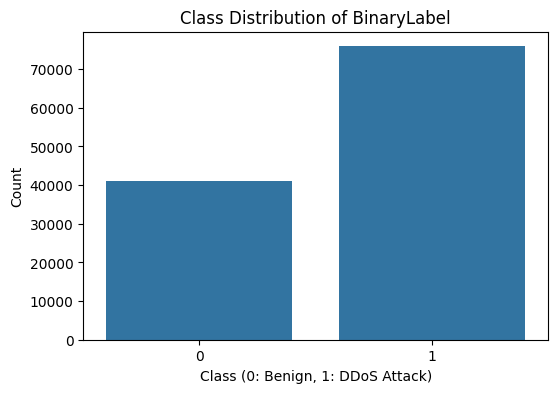

BinaryLabel
1    75890
0    40980
Name: count, dtype: int64


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check the class distribution
plt.figure(figsize=(6,4))
sns.countplot(x="BinaryLabel", data=train_df)
plt.title("Class Distribution of BinaryLabel")
plt.xlabel("Class (0: Benign, 1: DDoS Attack)")
plt.ylabel("Count")
plt.show()

# Print actual counts
print(train_df["BinaryLabel"].value_counts())


Compute and Visualize the Correlation Matrix

In [ ]:
train_df = train_df.drop(columns=["Label"], errors="ignore")
test_df = test_df.drop(columns=["Label"], errors="ignore")

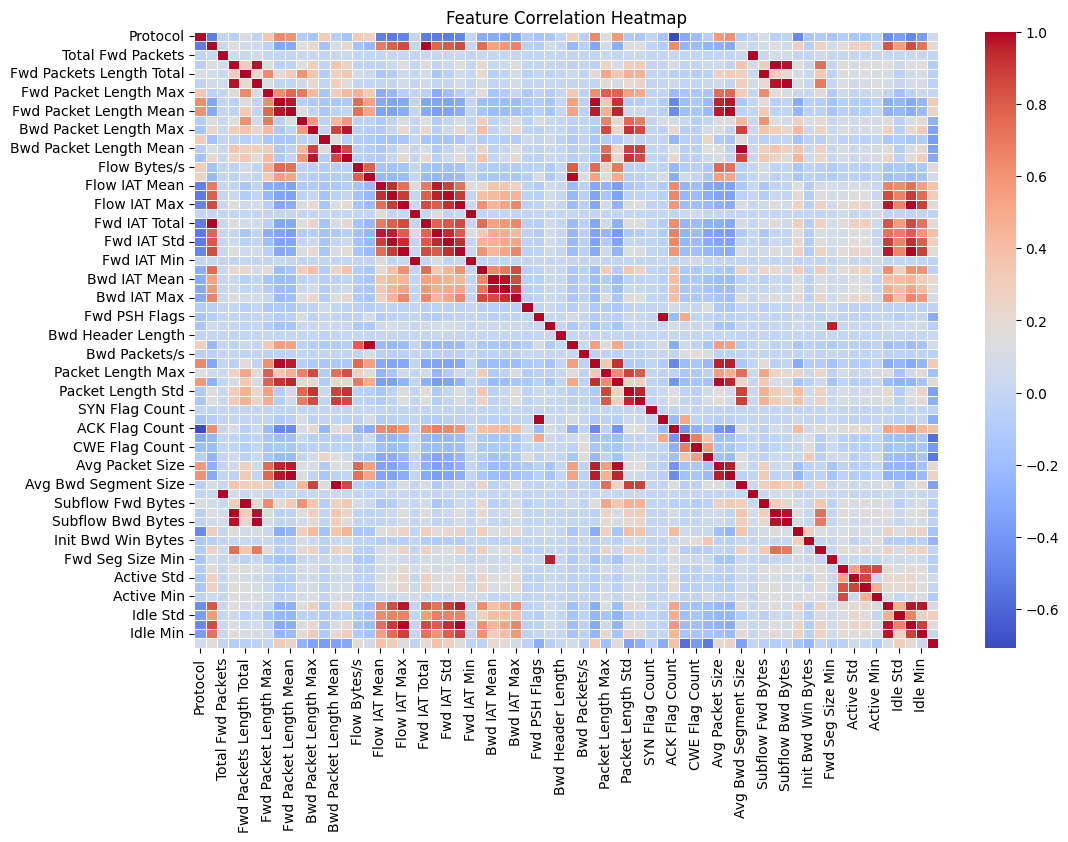

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = train_df.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False, fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


In [ ]:
threshold = 0.9
corr_matrix = train_df.corr()
high_corr_features = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname = corr_matrix.columns[i]
            high_corr_features.add(colname)

print("Highly correlated features (above 0.9):", high_corr_features)


Highly correlated features (above 0.9): {'Fwd Packet Length Mean', 'Fwd Seg Size Min', 'Fwd IAT Mean', 'Subflow Bwd Packets', 'Packet Length Mean', 'Fwd Packets/s', 'Fwd IAT Total', 'Idle Mean', 'Avg Packet Size', 'Idle Max', 'RST Flag Count', 'Subflow Bwd Bytes', 'Packet Length Min', 'Bwd Packet Length Std', 'Bwd IAT Max', 'Bwd IAT Std', 'Subflow Fwd Packets', 'Flow IAT Std', 'Fwd IAT Std', 'Fwd IAT Max', 'Packet Length Std', 'Subflow Fwd Bytes', 'Avg Fwd Segment Size', 'Idle Min', 'Packet Length Variance', 'Fwd IAT Min', 'Avg Bwd Segment Size', 'Bwd Packets Length Total'}


In [ ]:
drop_cols = [
    'Fwd Packet Length Mean', 'Fwd IAT Total', 'Avg Bwd Segment Size',
    'Fwd IAT Max', 'Fwd Seg Size Min', 'Idle Min', 'Fwd Packets/s',
    'Bwd Packet Length Std', 'Avg Fwd Segment Size', 'Packet Length Mean',
    'Subflow Fwd Bytes', 'Packet Length Min', 'Bwd Packets Length Total',
    'Idle Max', 'Bwd IAT Std', 'Fwd IAT Min', 'Subflow Bwd Packets',
    'RST Flag Count', 'Flow IAT Std', 'Subflow Fwd Packets', 'Avg Packet Size',
    'Fwd IAT Std', 'Idle Mean', 'Fwd IAT Mean', 'Packet Length Std',
    'Subflow Bwd Bytes', 'Packet Length Variance', 'Bwd IAT Max'
]

train_df = train_df.drop(columns=drop_cols)
test_df = test_df.drop(columns=drop_cols)


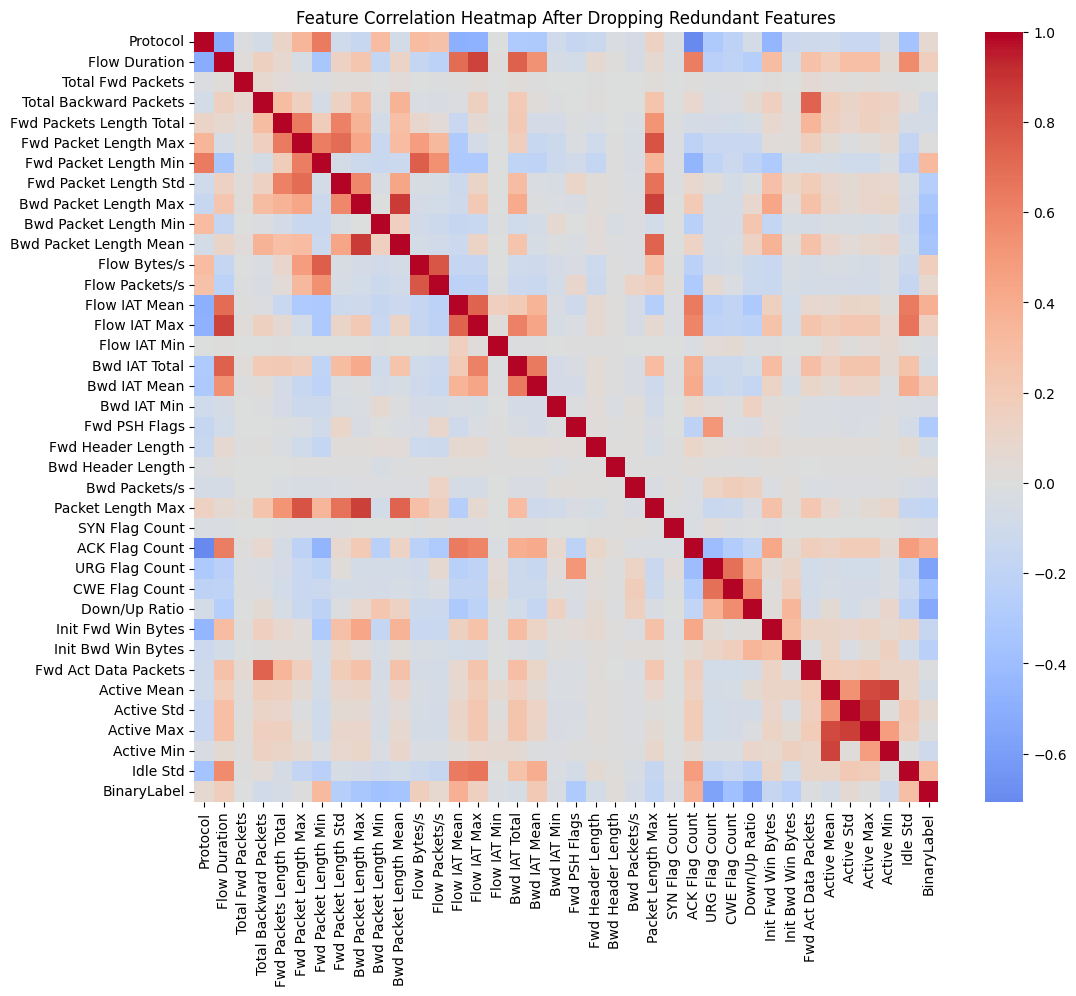

In [ ]:
# Recalculate the correlation matrix
corr_matrix = train_df.corr()

# Replot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap After Dropping Redundant Features")
plt.show()

In [ ]:
train_df.columns


Index(['Protocol', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Fwd Packets Length Total',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Max', 'Flow IAT Min',
       'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Fwd Header Length', 'Bwd Header Length', 'Bwd Packets/s',
       'Packet Length Max', 'SYN Flag Count', 'ACK Flag Count',
       'URG Flag Count', 'CWE Flag Count', 'Down/Up Ratio',
       'Init Fwd Win Bytes', 'Init Bwd Win Bytes', 'Fwd Act Data Packets',
       'Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Std',
       'BinaryLabel'],
      dtype='object')

Train and validation split

In [ ]:
from sklearn.model_selection import train_test_split

X = train_df.drop(columns=["BinaryLabel"])
y = train_df["BinaryLabel"]

# We'll do an 80/20 split for train/val. Adjust test_size as you like (e.g., 0.2 -> 20% val).
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train set shape:", X_train.shape, y_train.shape)
print("Val set shape:", X_val.shape, y_val.shape)
print("Test set shape:", test_df.shape, test_df["BinaryLabel"].shape)  # Already separate

print("Train set shape:", X_train.shape, y_train.shape)
print("Val set shape:", X_val.shape, y_val.shape)


Train set shape: (93496, 37) (93496,)
Val set shape: (23374, 37) (23374,)
Test set shape: (38731, 38) (38731,)
Train set shape: (93496, 37) (93496,)
Val set shape: (23374, 37) (23374,)


Scaling the data

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()


In [ ]:
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)

In [ ]:
print("X_train_scaled range:", X_train_scaled.min(), X_train_scaled.max())
print("X_val_scaled range:", X_val_scaled.min(), X_val_scaled.max())


X_train_scaled range: 0.0 1.0
X_val_scaled range: 0.0 1.3157831855581903


SMOTE Balancing

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

In [ ]:
import numpy as np

unique, counts = np.unique(y_train_bal, return_counts=True)
print("Balanced training set distribution:", dict(zip(unique, counts)))


Balanced training set distribution: {np.int32(0): np.int64(60712), np.int32(1): np.int64(60712)}


Model Building

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, LSTM, Bidirectional, Conv1D, MaxPooling1D, Dropout, BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

def build_cnn_lstm_model(input_shape):

    model = Sequential()

    # ---------------- CNN LAYERS ---------------- #
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same',
                     kernel_regularizer=l2(0.001), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same',
                     kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same',
                     kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())

    # ---------------- LSTM LAYERS ---------------- #
    model.add(Bidirectional(LSTM(units=64, return_sequences=True, kernel_regularizer=l2(0.001))))
    model.add(Dropout(0.5))

    model.add(LSTM(units=64, kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))

    # ---------------- HIDDEN DENSE LAYER (NEW) ---------------- #
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))

    # ---------------- OUTPUT LAYER ---------------- #
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)))

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


Training

Reshape

In [ ]:
# 3) Reshape for CNN-LSTM
X_train_bal_reshaped = X_train_bal.reshape(X_train_bal.shape[0], X_train_bal.shape[1], 1)
X_val_reshaped       = X_val_scaled.reshape(X_val_scaled.shape[0], X_val_scaled.shape[1], 1)

Train

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Build model
model = build_cnn_lstm_model(input_shape=(X_train_bal.shape[1], 1))

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # stops after 5 epochs with no val_loss improvement
    restore_best_weights=True
)

# Train
history = model.fit(
    X_train_bal_reshaped, y_train_bal,
    validation_data=(X_val_reshaped, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],  # pass it here
    verbose=1
)


Epoch 1/50
3795/3795 ━━━━━━━━━━━━━━━━━━━━ 67s 15ms/step - accuracy: 0.9860 - loss: 0.3075 - val_accuracy: 0.9964 - val_loss: 0.0645
Epoch 2/50
3795/3795 ━━━━━━━━━━━━━━━━━━━━ 77s 15ms/step - accuracy: 0.9970 - loss: 0.0569 - val_accuracy: 0.9969 - val_loss: 0.0413
Epoch 3/50
3795/3795 ━━━━━━━━━━━━━━━━━━━━ 85s 16ms/step - accuracy: 0.9968 - loss: 0.0406 - val_accuracy: 0.9970 - val_loss: 0.0357
Epoch 4/50
3795/3795 ━━━━━━━━━━━━━━━━━━━━ 79s 15ms/step - accuracy: 0.9974 - loss: 0.0340 - val_accuracy: 0.9935 - val_loss: 0.0473
Epoch 5/50
3795/3795 ━━━━━━━━━━━━━━━━━━━━ 83s 15ms/step - accuracy: 0.9974 - loss: 0.0314 - val_accuracy: 0.3879 - val_loss: 2.9805
Epoch 6/50
3795/3795 ━━━━━━━━━━━━━━━━━━━━ 80s 15ms/step - accuracy: 0.9972 - loss: 0.0316 - val_accuracy: 0.9964 - val_loss: 0.0328
Epoch 7/50
3795/3795 ━━━━━━━━━━━━━━━━━━━━ 83s 15ms/step - accuracy: 0.9977 - loss: 0.0275 - val_accuracy: 0.9883 - val_loss: 0.0686
Epoch 8/50
3795/3795 ━━━━━━━━━━━━━━━━━━━━ 86s 16ms/step - accuracy: 0.9976 -

Testing

In [ ]:
X_test = test_df.drop(columns=["BinaryLabel"])  # features
y_test = test_df["BinaryLabel"]                # labels (0 or 1)


In [ ]:
X_test_scaled = scaler.transform(X_test)  # do not fit again, just transform


In [ ]:
X_test_reshaped = X_test_scaled.reshape(
    (X_test_scaled.shape[0], X_test_scaled.shape[1], 1)
)


In [ ]:
test_loss, test_acc = model.evaluate(X_test_reshaped, y_test, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")


1211/1211 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9953 - loss: 0.0313
Test Accuracy: 0.9960
Test Loss: 0.0274


In [ ]:
# Save the entire model (architecture + weights + optimizer state)
model.save("/content/drive/MyDrive/CNNLSTM9945.keras")


In [ ]:
X_train.columns

Index(['Protocol', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Fwd Packets Length Total',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Max', 'Flow IAT Min',
       'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Fwd Header Length', 'Bwd Header Length', 'Bwd Packets/s',
       'Packet Length Max', 'SYN Flag Count', 'ACK Flag Count',
       'URG Flag Count', 'CWE Flag Count', 'Down/Up Ratio',
       'Init Fwd Win Bytes', 'Init Bwd Win Bytes', 'Fwd Act Data Packets',
       'Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Std'],
      dtype='object')

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = (model.predict(X_test_reshaped) > 0.5).astype(int)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


1211/1211 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
[[10587    18]
 [  135 27991]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     10605
           1       1.00      1.00      1.00     28126

    accuracy                           1.00     38731
   macro avg       0.99      1.00      1.00     38731
weighted avg       1.00      1.00      1.00     38731

